# GlobeStay Marketing Response Models (by Country)

**Channels (Digital Awareness):**
*   display (display_net_spend_eur) (dp_imps)
*   Youtube (yt_cost) (yt_imps)
*   Facebook (fb_cost) (fb_imps)
*   OLV (olv_spend_eur) (olv_imps)

**Models:**
1. A **log–log** (OLS) model (elasticities directly from coefficients)
2. An **ADBUDG** response model (nonlinear saturation: \(f(X)=a\,X^c/(X^c+d)\))

**Controls included:**
- Competition: `meta_comp_grp`, `ota_comp_grp` (log1p transformed)
- Seasonality: weekly Fourier terms (K=2)
- Trend: per-country time index
- Holidays: specified dummy columns (binary)

**Outputs:**
- Elasticities & marginal ROI (bookings per currency unit) for both models
- Diagnostic plots and response curves (matplotlib only, one chart per figure)
- Next-dollar **budget allocation recommendations** (raw & adjusted)

> **Note:** Financial ROI requires a contribution per booking. Here we report *bookings per currency*. Multiply by average contribution per booking to convert to financial ROI.

In [1]:
# Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from scipy.optimize import least_squares

pd.set_option('display.max_columns', 150)
plt.rcParams.update({'figure.dpi': 120})

# Parameters
DATA_PATH = '../data/cleaned_globestay.parquet'
OUTPUT_DIR = '../output/digital_awareness/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
df = pd.read_parquet(DATA_PATH)
df.head()


,sales_direct,olv_imps,value_currency_rate,thanksgivingday_us_ca,cost_remarketing,martinl_kingsday_us_ca,presidentsday_us_ca,independenceday_us_ca,meta_comp_grp,cost_ppc_non_brand,boxingday,sales_emk,eastermonday,sales_ppc_brand,olv_net_spend_eur,eastersunday,radio_net_spend_eur,labourday_de_nw,sales_shop_tripadvisor,clicks_remarketing,sales_interco,mayday_gb_en,sales_shop_googleha,cost_email,sales_strat_part,fb_imps,remembrance_memorialday_us_ca,fb_cost,clicks_shop_trivago,clicks_email,cost_shop_other,brandtv_net_spend_eur,clicks_shop_other,country,weekstart,clicks_shop_googleha,display_imps,cost_ppc_brand,christmasday,christsascensionday_de_nw,cost_shop_tripadvisor,drtv_grp,ooh_net_spend_eur,yt_cost,newyearsday,sales_shop_trivago,stvalentinesday,display_net_spend_eur,whitmonday_de_nw,germanunityday_de_nw,bankholiday_gb_en,ota_comp_grp,clicks_shop_tripadvisor,cost_shop_trivago,sales_retargeting,cost_shop_googleha,cinema_net_spend_eur,sales_shop_other,totbookings,yt_imps,sales_ppc_nonbrand,clicks_ppc_non_brand,print_net_spend_eur,drtv_net_spend_eur,brandtv_grp,clicks_ppc_brand,labourday_us_ca,_source_sheet,country_std,week_start
0,183169.0,0.0,1.0,0.0,58684.506092,0.0,0.0,0.0,926.0,2.196494e+06,0.0,16703.0,0.0,48228.0,0.0,0.0,0.0,0.0,9503.0,172069.878486,867.0,0.0,10423.0,0.0,16547.0,0.0,0.0,0.000000,8.478270e+05,474859.0,103139.320644,0.0,250527.000002,de,2016-01-04,133462.122833,0.0,68560.240287,0.0,0.0,283108.460235,0.0,0.0,0.000000,0.0,18302.0,0.0,0.0,0.0,0.0,0.0,321.0,367987.978037,377911.565361,2040.0,170087.676546,0.0,4678.0,398268.0,12.0,87808.0,2.496438e+06,0.0,0.0,0.0,378640.216496,0.0,Sheet1,58684.506091931464,NaT
1,184480.0,0.0,1.0,0.0,76380.207088,0.0,0.0,0.0,706.0,2.306422e+06,0.0,16278.0,0.0,49076.0,0.0,0.0,0.0,0.0,9143.0,198123.396746,858.0,0.0,11107.0,0.0,17340.0,57831.0,0.0,89.386325,9.612325e+05,478024.0,116137.878276,0.0,278878.649717,de,2016-01-11,136016.480131,0.0,70502.248076,0.0,0.0,257639.565836,0.0,0.0,0.000000,0.0,21148.0,0.0,0.0,0.0,0.0,0.0,225.0,353354.844840,471254.197728,2236.0,193176.386595,0.0,5019.0,404068.0,247.0,87383.0,2.520208e+06,0.0,0.0,0.0,386722.377913,0.0,Sheet1,76380.20708756169,NaT
2,178895.0,0.0,1.0,0.0,81636.483459,1.0,0.0,0.0,813.0,2.379034e+06,0.0,15822.0,0.0,45575.0,0.0,0.0,0.0,0.0,8568.0,186402.476444,806.0,0.0,10048.0,0.0,16873.0,104754.0,0.0,231.027642,9.127736e+05,482391.0,116345.872180,0.0,288057.500725,de,2016-01-18,126167.255474,0.0,61647.322276,0.0,0.0,247711.892237,0.0,0.0,1.459669,0.0,19715.0,0.0,0.0,0.0,0.0,0.0,231.0,332119.415416,439863.176592,2224.0,191568.477802,0.0,4963.0,388746.0,10249.0,85257.0,2.538803e+06,0.0,0.0,0.0,372694.075197,0.0,Sheet1,81636.48345888322,NaT
3,178961.0,0.0,1.0,0.0,97974.916607,0.0,0.0,0.0,1249.0,2.342182e+06,0.0,15441.0,0.0,46037.0,0.0,0.0,0.0,0.0,8065.0,203471.161091,770.0,0.0,10234.0,0.0,17386.0,0.0,0.0,0.000000,1.063155e+06,477310.0,117989.868406,0.0,281681.767054,de,2016-01-25,127212.718534,0.0,58113.630201,0.0,0.0,220940.048133,0.0,0.0,4.025302,0.0,22804.0,0.0,0.0,0.0,0.0,0.0,224.0,299462.651303,499118.517506,2498.0,210296.033518,0.0,5266.0,391945.0,6144.0,84483.0,2.520338e+06,0.0,0.0,0.0,367930.614827,0.0,Sheet1,97974.91660718997,NaT
4,178238.0,0.0,1.0,0.0,95282.006389,0.0,0.0,0.0,772.0,2.242276e+06,0.0,15610.0,0.0,45020.0,0.0,0.0,0.0,0.0,7610.0,205548.009831,807.0,0.0,10490.0,0.0,17840.0,248451.0,0.0,476.436307,1.059135e+06,475233.0,123253.978573,0.0,259377.433805,de,2016-02-01,130732.603895,0.0,56688.931152,0.0,0.0,204314.700744,0.0,0.0,0.009987,0.0,23259.0,0.0,0.0,0.0,0.0,0.0,341.0,281375.925071,487391.446449,2481.0,214412.055927,0.0,5186.0,389989.0,2.0,83448.0,2.354455e+06,0.0,0.0,0.0,352899.330762,0.0,Sheet1,95282.00638886205,NaT


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 70 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   sales_direct                   576 non-null    float64       
 1   olv_imps                       576 non-null    float64       
 2   value_currency_rate            576 non-null    float64       
 3   thanksgivingday_us_ca          576 non-null    float64       
 4   cost_remarketing               576 non-null    float64       
 5   martinl_kingsday_us_ca         576 non-null    float64       
 6   presidentsday_us_ca            576 non-null    float64       
 7   independenceday_us_ca          576 non-null    float64       
 8   meta_comp_grp                  576 non-null    float64       
 9   cost_ppc_non_brand             576 non-null    float64       
 10  boxingday                      576 non-null    float64       
 11  sales_emk          

In [3]:
SELECTED_COLS_DIGITAL = [
    # Competition
    'meta_comp_grp','ota_comp_grp',
    # Controls
    'country','weekstart',
    # Holidays
    'presidentsday_us_ca','labourday_de_nw','boxingday','eastermonday','martinl_kingsday_us_ca',
    'remembrance_memorialday_us_ca','independenceday_us_ca','stvalentinesday','eastersunday',
    'christsascensionday_de_nw','labourday_us_ca','whitmonday_de_nw','bankholiday_gb_en',
    'thanksgivingday_us_ca','germanunityday_de_nw','mayday_gb_en','newyearsday','christmasday',
    # Digital Channels (Cost and Impressions)
    'display_net_spend_eur','display_imps',
    'yt_cost','yt_imps',
    'fb_cost','fb_imps',
    'olv_net_spend_eur','olv_imps',
    # Currency normalization
    'value_currency_rate',
]


In [4]:
# Load data (only selected columns for digital channels)
df = pd.read_parquet(DATA_PATH)  # make sure DATA_PATH points to your digital data file
df = df[[c for c in SELECTED_COLS_DIGITAL if c in df.columns]].copy()
df['weekstart'] = pd.to_datetime(df['weekstart'])
countries = sorted(df['country'].dropna().unique().tolist())

# Display first 3 rows and basic info
display(df.head(3))
print('Rows:', len(df), '| Countries:', countries)


,meta_comp_grp,ota_comp_grp,country,weekstart,presidentsday_us_ca,labourday_de_nw,boxingday,eastermonday,martinl_kingsday_us_ca,remembrance_memorialday_us_ca,independenceday_us_ca,stvalentinesday,eastersunday,christsascensionday_de_nw,labourday_us_ca,whitmonday_de_nw,bankholiday_gb_en,thanksgivingday_us_ca,germanunityday_de_nw,mayday_gb_en,newyearsday,christmasday,display_net_spend_eur,display_imps,yt_cost,yt_imps,fb_cost,fb_imps,olv_net_spend_eur,olv_imps,value_currency_rate
0,926.0,321.0,de,2016-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,12.0,0.000000,0.0,0.0,0.0,1.0
1,706.0,225.0,de,2016-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,247.0,89.386325,57831.0,0.0,0.0,1.0
2,813.0,231.0,de,2016-01-18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.459669,10249.0,231.027642,104754.0,0.0,0.0,1.0


Rows: 576 | Countries: ['de', 'gb', 'us']


In [5]:
# Feature engineering for digital channels
# Seasonality features
df = df.sort_values(['country','weekstart']).copy()
df['t'] = df.groupby('country').cumcount() + 1
df['woy'] = df['weekstart'].dt.isocalendar().week.astype(int)

# FX-normalize digital channel costs
rate = df['value_currency_rate'].replace(0, np.nan).fillna(1.0)
for col in ['display_net_spend_eur', 'yt_cost', 'fb_cost', 'olv_net_spend_eur']:
    df[col+'_normalized'] = df[col] / rate


# Add Fourier terms
def add_fourier_terms(df_sub, K=2):
    for k in range(1, K+1):
        df_sub[f'sin_{k}'] = np.sin(2*np.pi*k*df_sub['woy']/52.0)
        df_sub[f'cos_{k}'] = np.cos(2*np.pi*k*df_sub['woy']/52.0)
    return df_sub

df = pd.concat(
    [add_fourier_terms(g.copy(), K=2).assign(country=iname) for iname, g in df.groupby('country')],
    axis=0,
)

# Fill NA holiday dummies with 0
holiday_cols = [
    'presidentsday_us_ca','labourday_de_nw','boxingday','eastermonday','martinl_kingsday_us_ca',
    'remembrance_memorialday_us_ca','independenceday_us_ca','stvalentinesday','eastersunday',
    'christsascensionday_de_nw','labourday_us_ca','whitmonday_de_nw','bankholiday_gb_en',
    'thanksgivingday_us_ca','germanunityday_de_nw','mayday_gb_en','newyearsday','christmasday'
]
df[holiday_cols] = df[holiday_cols].fillna(0)

# Create total impressions variable across all 4 digital channels
df['total_imps'] = df[['display_imps','yt_imps','fb_imps','olv_imps']].sum(axis=1)



## Log–log model by country
- Spec: `log(imps+1)` vs. `log(cost_*_normalized+1)
- HAC robust SE with `maxlags=4`.
- Elasticities = coefficients on log-costs.

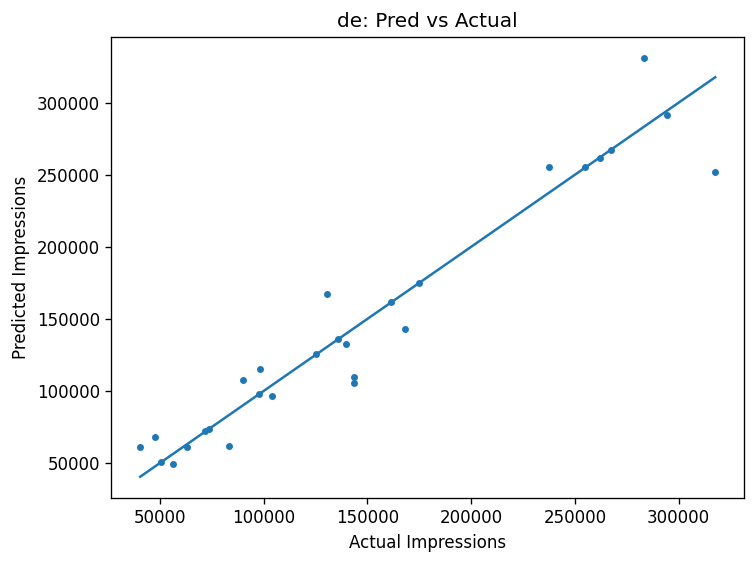

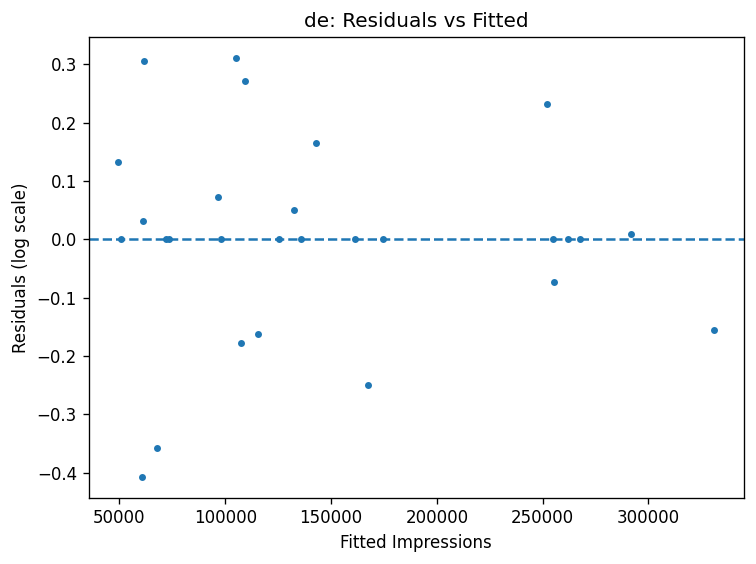

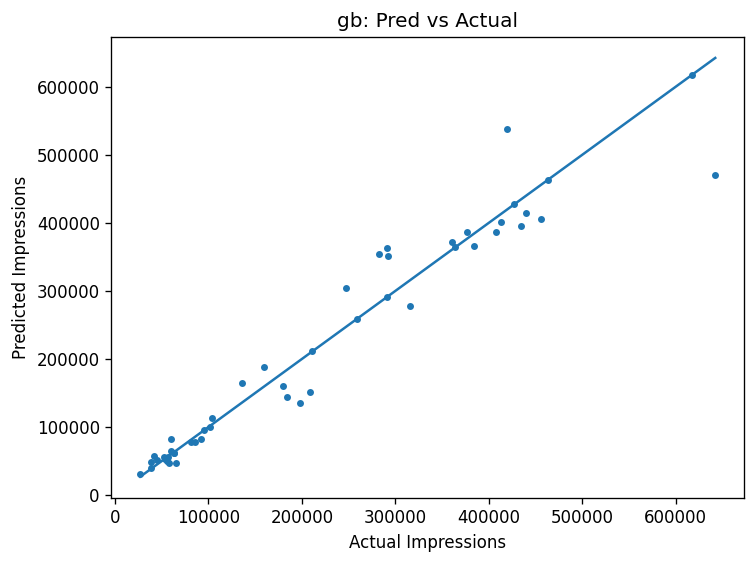

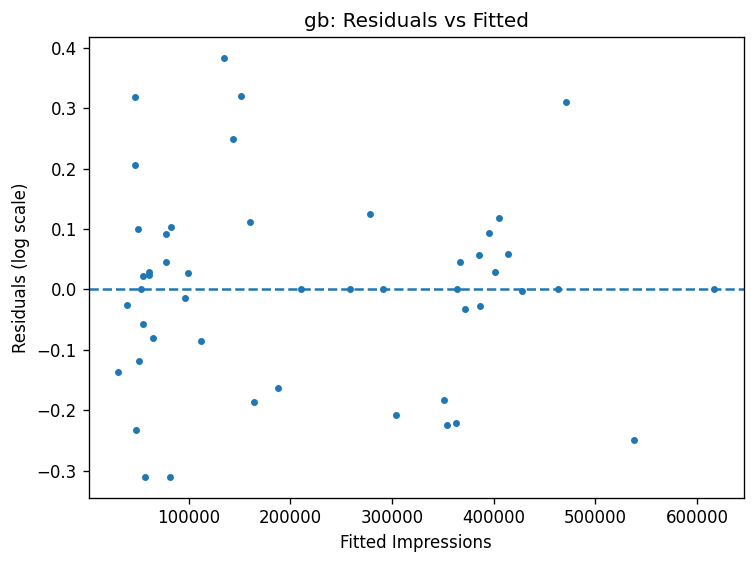

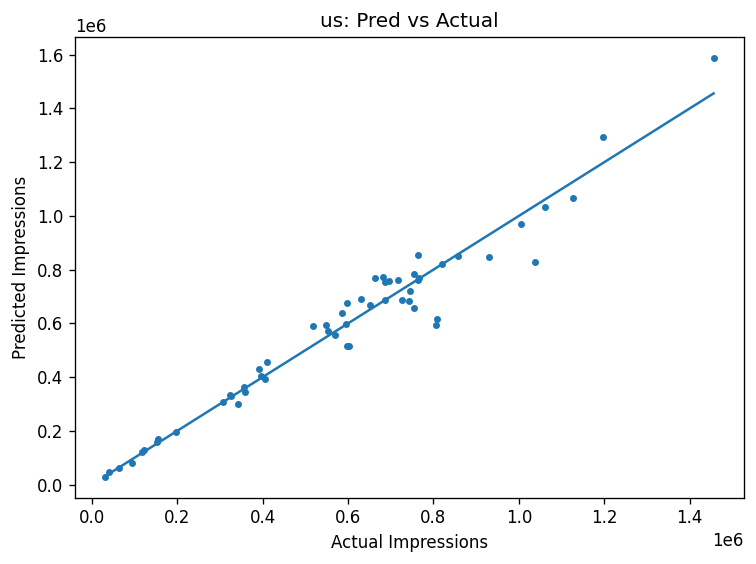

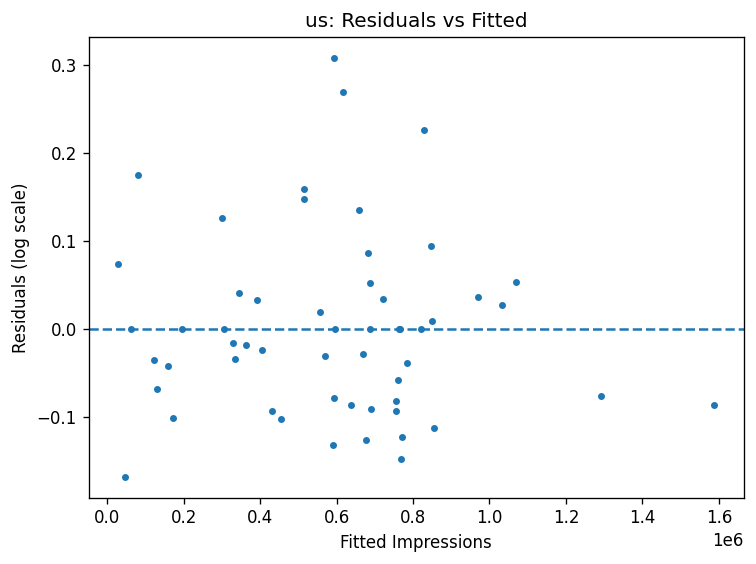

### Elasticities (Log-Log)

,country,channel,elasticity_loglog
0,de,Display,0.103232
1,de,YouTube,-0.018843
2,de,Facebook,0.021069
3,de,OLV,0.125909
4,gb,Display,0.324296
5,gb,YouTube,0.134304
6,gb,Facebook,0.154203
7,gb,OLV,0.139163
8,us,Display,0.487950
9,us,YouTube,0.075075


### Marginal Impressions per Dollar (Log-Log)

,country,channel,marginal_impressions_per_dollar_loglog
0,de,Display,0.520863
1,de,YouTube,-0.069232
2,de,Facebook,0.069688
3,de,OLV,0.441512
4,gb,Display,0.920552
5,gb,YouTube,0.635074
6,gb,Facebook,0.601777
7,gb,OLV,1.252125
8,us,Display,1.384872
9,us,YouTube,0.387682


In [6]:
# log-log model with proper zero handling
channels_digital = [
    ('Display', 'display_net_spend_eur_normalized'),
    ('YouTube', 'yt_cost_normalized'),
    ('Facebook', 'fb_cost_normalized'),
    ('OLV', 'olv_net_spend_eur_normalized')
]

def fit_loglog_country_imps(dfc, channels):
    # Filter out observations where ALL channel costs are zero
    cost_cols = [col for _, col in channels]
    has_spend = dfc[cost_cols].sum(axis=1) > 0
    dfc = dfc[has_spend].copy()

    if len(dfc) < 10:  # Minimum data threshold
        return None, None, None

    # Y: sum of impressions across channels (log of positive values only)
    total_imps = dfc[[col for _, col in channels]].sum(axis=1)
    valid_imps = total_imps > 0
    dfc = dfc[valid_imps].copy()

    y = np.log(total_imps[valid_imps])

    # X: ln(cost) of each channel (only for positive costs)
    X = pd.DataFrame()
    for ch, col in channels:
        cost_data = dfc[col].copy()
        # For zero costs, we can either filter or use small constant - here we filter
        positive_costs = cost_data > 0
        if positive_costs.any():
            # Keep only observations with positive cost for this channel
            X[f'ln_cost_{ch.lower()}'] = np.log(cost_data[positive_costs])
        else:
            X[f'ln_cost_{ch.lower()}'] = np.nan

    # Add controls
    X['meta_comp_grp'] = dfc['meta_comp_grp']
    X['ota_comp_grp'] = dfc['ota_comp_grp']
    X['t'] = dfc['t']
    X['sin_1'] = dfc['sin_1']
    X['cos_1'] = dfc['cos_1']
    X['sin_2'] = dfc['sin_2']
    X['cos_2'] = dfc['cos_2']
    X[holiday_cols] = dfc[holiday_cols]

    # Drop rows with missing values (where costs were zero)
    X = X.dropna()
    y = y.loc[X.index]

    if len(X) < 10:
        return None, None, None

    X = add_constant(X, has_constant='add')

    model = OLS(y, X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':4})
    return model, X, y

# Update the fitting loop
loglog_results = {}
elasticity_rows, roi_rows = [], []

# Fit models and compute diagnostics
for ctry in countries:
    dsub = df[df['country']==ctry].copy()
    if len(dsub) < 30:
        display(Markdown(f"**Skipping {ctry}**: not enough data"))
        continue

    mdl, X, y = fit_loglog_country_imps(dsub, channels_digital)
    loglog_results[ctry] = mdl
    yhat = mdl.predict(X)

    # Diagnostics: predicted vs actual (levels)
    plt.figure()
    plt.scatter(np.expm1(y), np.expm1(yhat), s=10)
    lo, hi = float(np.expm1(y).min()), float(np.expm1(y).max())
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel('Actual Impressions'); plt.ylabel('Predicted Impressions'); plt.title(f'{ctry}: Pred vs Actual')
    plt.tight_layout(); plt.show(); plt.close()

    # Residuals vs fitted
    resid = y - yhat
    plt.figure()
    plt.scatter(np.expm1(yhat), resid, s=10)
    plt.axhline(0, linestyle='--')
    plt.xlabel('Fitted Impressions'); plt.ylabel('Residuals (log scale)'); plt.title(f'{ctry}: Residuals vs Fitted')
    plt.tight_layout(); plt.show(); plt.close()

    # Elasticities and marginal impressions per dollar
    elasticities = {ch: mdl.params.get(f'ln_cost_{ch.lower()}', np.nan) for ch, _ in channels_digital}
    mean_Y = np.expm1(y).mean()
    mean_costs = {ch: dsub[col].replace(0,np.nan).mean() for ch, col in channels_digital}

    for ch, beta in elasticities.items():
        Xbar = mean_costs.get(ch, np.nan)
        if np.isnan(beta) or Xbar <= 0:
            m_ipd = np.nan
        else:
            m_ipd = beta * (mean_Y / Xbar)  # marginal impressions per dollar
        elasticity_rows.append({'country': ctry, 'channel': ch, 'elasticity_loglog': beta})
        roi_rows.append({'country': ctry, 'channel': ch, 'marginal_impressions_per_dollar_loglog': m_ipd})

elasticity_df = pd.DataFrame(elasticity_rows)
roi_df = pd.DataFrame(roi_rows)

display(Markdown('### Elasticities (Log-Log)'))
display(elasticity_df)
display(Markdown('### Marginal Impressions per Dollar (Log-Log)'))
display(roi_df)


## ADBUDG model (nonlinear saturation) by country
Controls-only baseline → incremental imps → ADBUDG curves per channel combined.


=== FITTING DE ===
  Display: spend=[0.0, 134621.6], impressions=[1990, 381030]
✓ Display: a=270386, c=0.879, d=7027 (n=147)
  YouTube: spend=[0.0, 104385.4], impressions=[4, 317699]
✓ YouTube: a=285697, c=1.301, d=761213 (n=91)
  Facebook: spend=[0.1, 206401.2], impressions=[89, 381030]
✓ Facebook: a=226634, c=0.800, d=2846 (n=187)
  OLV: spend=[0.6, 237800.6], impressions=[1072, 381030]
✓ OLV: a=205884, c=0.800, d=3138 (n=119)


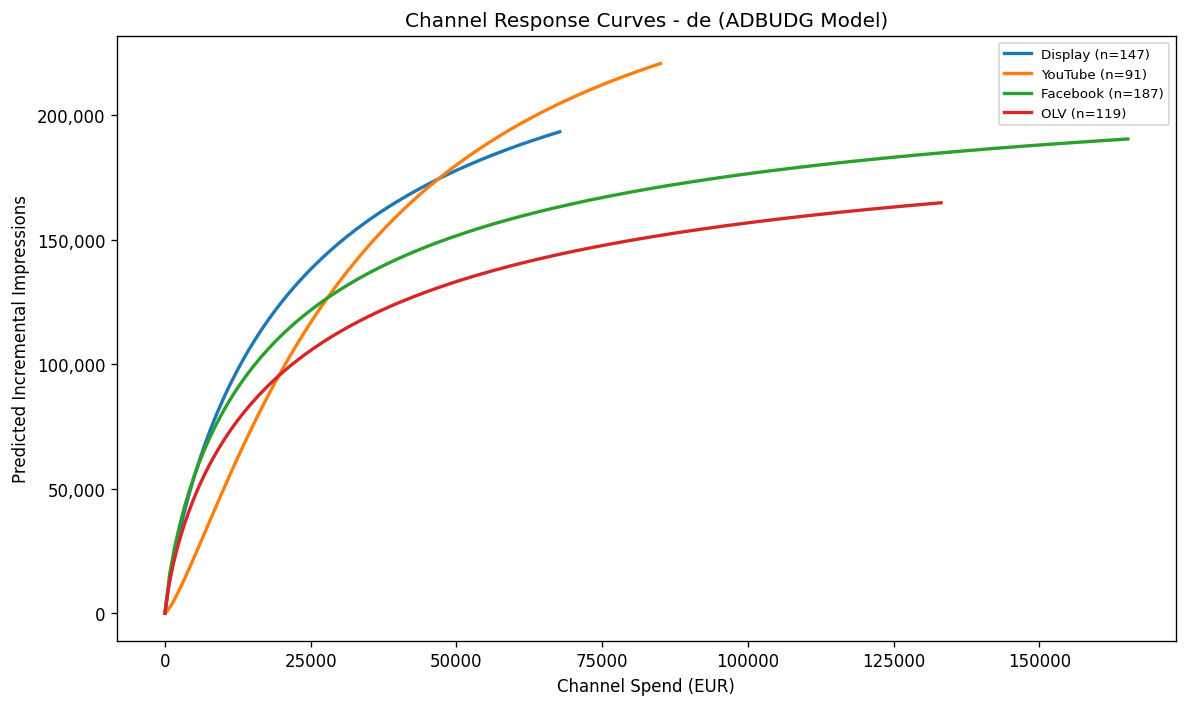


=== FITTING GB ===
  Display: spend=[0.7, 269730.9], impressions=[6613, 642365]
✓ Display: a=307341, c=1.106, d=102697 (n=160)
  YouTube: spend=[0.0, 163967.6], impressions=[918, 642365]
✓ YouTube: a=389500, c=1.548, d=10000000 (n=113)
  Facebook: spend=[20.1, 389704.2], impressions=[376, 642365]
✓ Facebook: a=327789, c=1.102, d=96336 (n=194)
  OLV: spend=[0.0, 127793.6], impressions=[1631, 642365]
✓ OLV: a=251747, c=1.189, d=68386 (n=129)


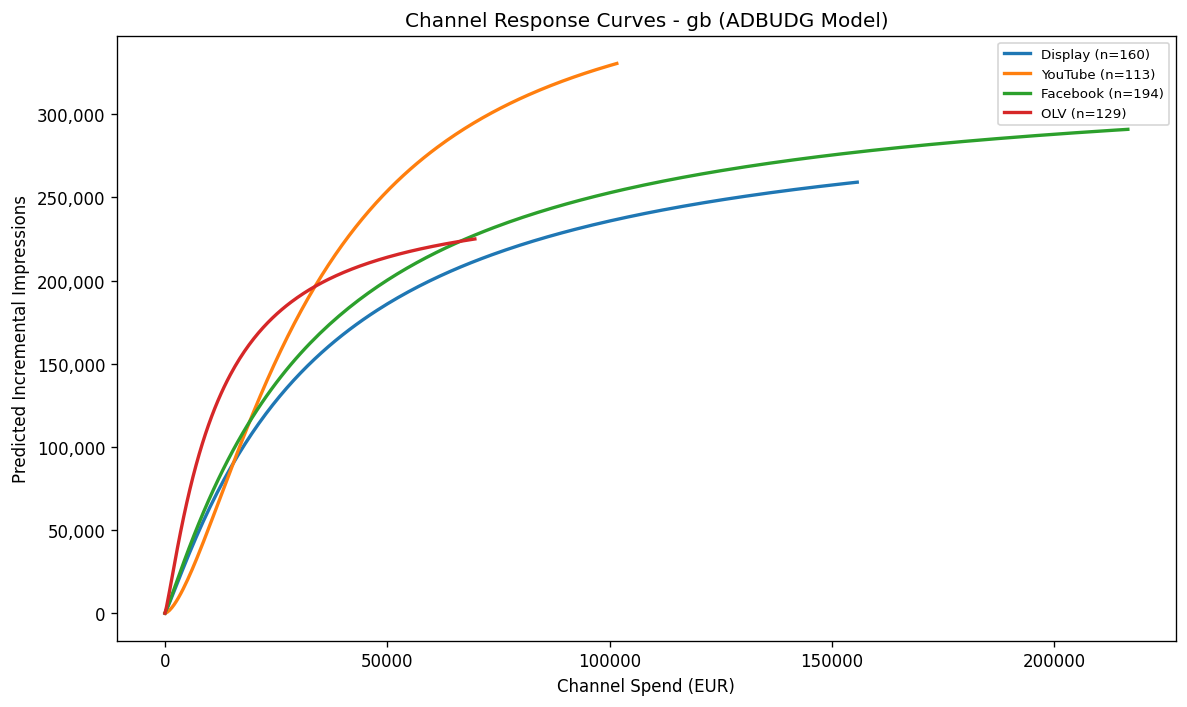


=== FITTING US ===
  Display: spend=[0.0, 1095093.5], impressions=[60, 1455910]
✓ Display: a=977156, c=1.254, d=3094209 (n=170)
  YouTube: spend=[0.0, 345796.0], impressions=[234, 1455910]
✓ YouTube: a=962162, c=0.800, d=5022 (n=101)
  Facebook: spend=[2.1, 509365.2], impressions=[60, 1455910]
✓ Facebook: a=667011, c=0.800, d=2150 (n=189)
  OLV: spend=[0.0, 383978.7], impressions=[60, 1455910]
✓ OLV: a=745569, c=0.800, d=4538 (n=114)


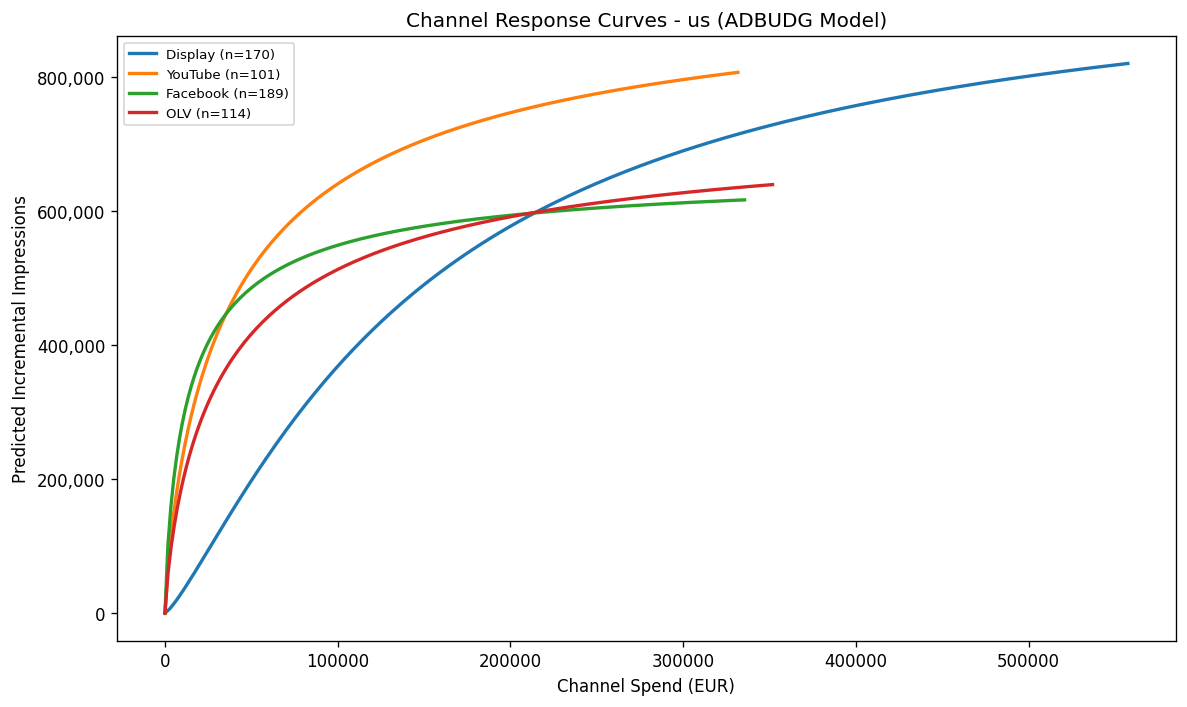

### ADBUDG Parameters (a, c, d)

,country,channel,a,c,d
0,de,Display,270385.683226,0.878915,7.026723e+03
1,de,YouTube,285696.932538,1.300796,7.612134e+05
2,de,Facebook,226634.231387,0.800000,2.846212e+03
3,de,OLV,205884.467264,0.800000,3.138243e+03
4,gb,Display,307341.034870,1.105981,1.026966e+05
5,gb,YouTube,389499.525400,1.547633,1.000000e+07
6,gb,Facebook,327788.510243,1.102337,9.633553e+04
7,gb,OLV,251747.495684,1.189439,6.838570e+04
8,us,Display,977156.467862,1.254484,3.094209e+06
9,us,YouTube,962162.464408,0.800000,5.021846e+03


### Elasticities (ADBUDG)

,country,channel,elasticity_ADBUDG_total
0,de,Display,0.436004
1,de,YouTube,0.640960
2,de,Facebook,0.365188
3,de,OLV,0.379248
4,gb,Display,0.361789
5,gb,YouTube,0.724098
6,gb,Facebook,0.506478
7,gb,OLV,0.409172
8,us,Display,0.601638
9,us,YouTube,0.296431


### Marginal Impressions per Dollar (ADBUDG)

,country,channel,marginal_impressions_per_dollar_ADBUDG
0,de,Display,2.022537
1,de,YouTube,2.287753
2,de,Facebook,0.930827
3,de,OLV,0.930992
4,gb,Display,0.894474
5,gb,YouTube,3.025573
6,gb,Facebook,1.469828
7,gb,OLV,2.525016
8,us,Display,1.420857
9,us,YouTube,1.452750


In [7]:
# Define digital channels for ADBUDG
channels_digital = [
    ('Display', 'display_net_spend_eur_normalized'),
    ('YouTube', 'yt_cost_normalized'),
    ('Facebook', 'fb_cost_normalized'),
    ('OLV', 'olv_net_spend_eur_normalized')
]

adb_params_rows, adb_elasticity_rows, adb_roi_rows = [], [], []

# Fit ADBUDG models by country for digital channels (outcome = total impressions)
for ctry in countries:
    print(f"\n=== FITTING {ctry.upper()} ===")

    # Create individual plots for each country
    plt.figure(figsize=(10, 6))

    for j, (ch, col) in enumerate(channels_digital):
        dsub_channel = df[df['country']==ctry].copy()

        # Use ONLY rows where THIS channel has positive spend
        dsub_channel = dsub_channel[dsub_channel[col] > 0]

        if len(dsub_channel) < 10:
            print(f"Skipping {ch}: only {len(dsub_channel)} positive spend rows")
            continue

        # Use total impressions as y (all channels combined)
        y_inc = dsub_channel[[col for _, col in channels_digital]].sum(axis=1).values

        # X: only this channel's spend (ignore others)
        X_single = dsub_channel[col].values

        # Debug: print data ranges
        print(f"  {ch}: spend=[{X_single.min():.1f}, {X_single.max():.1f}], impressions=[{y_inc.min():.0f}, {y_inc.max():.0f}]")

        # Single-channel ADBUDG fit
        def residual_single(params, x, y):
            a, c, d = params
            y_hat = a * (np.power(x, c) / (np.power(x, c) + d + 1e-9))
            return y - y_hat

        # Initial params
        a0 = y_inc.mean() * 0.5
        c0 = 1.5
        d0 = np.median(X_single)
        p0 = [a0, c0, d0]

        bounds = ([0, 0.8, 10], [2*y_inc.mean(), 2.5, 1e7])

        try:
            res = least_squares(residual_single, p0, bounds=bounds, args=(X_single, y_inc))
            a, c, d = res.x

            print(f"✓ {ch}: a={a:.0f}, c={c:.3f}, d={d:.0f} (n={len(dsub_channel)})")

            # Plot curve
            xs = np.linspace(0, np.percentile(X_single, 95), 200)
            ys = a * (np.power(xs, c) / (np.power(xs, c) + d + 1e-9))

            plt.plot(xs, ys, label=f'{ch} (n={len(dsub_channel)})', linewidth=2)

            # Store parameters
            adb_params_rows.append({'country': ctry, 'channel': ch, 'a': a, 'c': c, 'd': d})

            # Calculate elasticity at mean spend
            Xbar = X_single.mean()
            if Xbar > 0:
                term1 = np.power(Xbar, c)
                term2 = term1 + d
                dfdX = a * c * d * (Xbar**(c-1)) / (term2**2)
                Ybar = y_inc.mean()
                e_total = dfdX * Xbar / Ybar if Ybar > 0 else np.nan
                m_ipd = dfdX
            else:
                e_total = np.nan
                m_ipd = np.nan

            adb_elasticity_rows.append({
                'country': ctry, 'channel': ch,
                'elasticity_ADBUDG_total': e_total
            })
            adb_roi_rows.append({
                'country': ctry, 'channel': ch,
                'marginal_impressions_per_dollar_ADBUDG': m_ipd
            })

        except Exception as e:
            print(f"✗ {ch}: Failed to fit - {e}")
            continue

# Format y-axis to remove scientific notation
    plt.xlabel('Channel Spend (EUR)')
    plt.ylabel('Predicted Incremental Impressions')
    plt.title(f'Channel Response Curves - {ctry} (ADBUDG Model)')
    plt.legend(fontsize=8)

    # Remove scientific notation from y-axis
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.tight_layout()
    plt.show()

adb_params_df = pd.DataFrame(adb_params_rows)
adb_elasticity_df = pd.DataFrame(adb_elasticity_rows)
adb_roi_df = pd.DataFrame(adb_roi_rows)

display(Markdown('### ADBUDG Parameters (a, c, d)'))
display(adb_params_df)
display(Markdown('### Elasticities (ADBUDG)'))
display(adb_elasticity_df)
display(Markdown('### Marginal Impressions per Dollar (ADBUDG)'))
display(adb_roi_df)

## Model comparison

In [8]:
# Model comparison per country/channel for digital channels
comparison_rows = []

for ctry in countries:
    for ch, _ in channels_digital:  # use digital channels
        loglog_elast = elasticity_df[
            (elasticity_df['country']==ctry) &
            (elasticity_df['channel']==ch)
        ]['elasticity_loglog'].values

        adb_elast = adb_elasticity_df[
            (adb_elasticity_df['country']==ctry) &
            (adb_elasticity_df['channel']==ch)
        ]['elasticity_ADBUDG_total'].values

        if len(loglog_elast)==0 or len(adb_elast)==0:
            continue

        loglog_elast = loglog_elast[0]
        adb_elast = adb_elast[0]

        # Choose model with higher absolute elasticity
        if abs(loglog_elast) >= abs(adb_elast):
            best_model = 'Log-Log'
            best_elast = loglog_elast
        else:
            best_model = 'ADBUDG'
            best_elast = adb_elast

        comparison_rows.append({
            'country': ctry,
            'channel': ch,
            'best_model': best_model,
            'best_elasticity': best_elast
        })

comparison_df = pd.DataFrame(comparison_rows)

display(Markdown('### Model Comparison and Best Model Selection (Digital Channels - Impressions)'))
display(comparison_df)



### Model Comparison and Best Model Selection (Digital Channels - Impressions)

,country,channel,best_model,best_elasticity
0,de,Display,ADBUDG,0.436004
1,de,YouTube,ADBUDG,0.640960
2,de,Facebook,ADBUDG,0.365188
3,de,OLV,ADBUDG,0.379248
4,gb,Display,ADBUDG,0.361789
5,gb,YouTube,ADBUDG,0.724098
6,gb,Facebook,ADBUDG,0.506478
7,gb,OLV,ADBUDG,0.409172
8,us,Display,ADBUDG,0.601638
9,us,YouTube,ADBUDG,0.296431


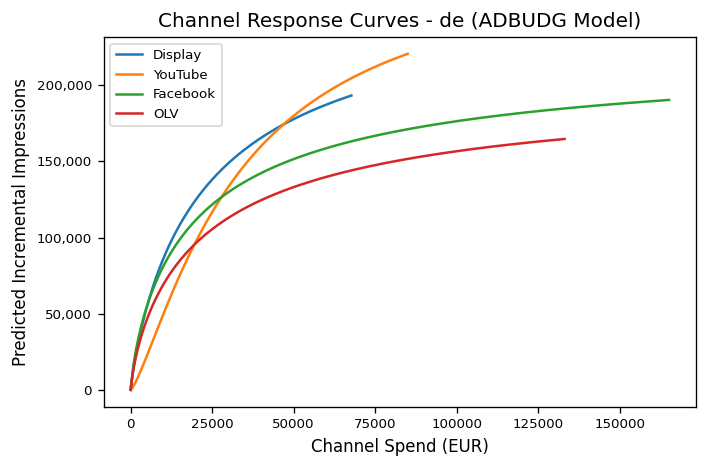

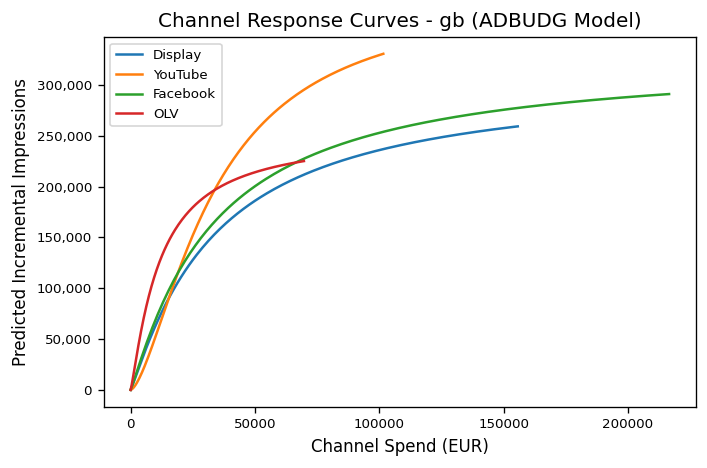

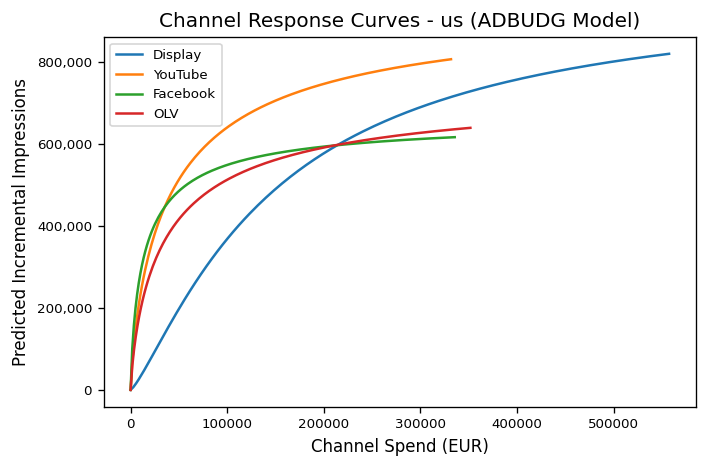

In [9]:
# --- Channel Response Curves (ADBUDG Model) ---

for ctry in countries:
    # Use cleaned data (same as fitting)
    dsub_clean = df[df['country']==ctry].copy()

    # Remove rows where ALL channels have zero spend (same as fitting process)
    all_zero_mask = (dsub_clean[[col for _, col in channels_digital]] == 0).all(axis=1)
    dsub_clean = dsub_clean[~all_zero_mask].copy()

    adb_ctry = adb_params_df[adb_params_df['country'] == ctry]

    if adb_ctry.empty:
        continue

    plt.figure(figsize=(6, 4))

    for ch, col in channels_digital:
        params_row = adb_ctry[adb_ctry['channel'] == ch]
        if params_row.empty:
            continue

        a = params_row['a'].values[0]
        c = params_row['c'].values[0]
        d = params_row['d'].values[0]

        # Use cleaned data for spend range
        channel_spends = dsub_clean[dsub_clean[col] > 0][col].values
        if len(channel_spends) == 0:
            continue

        x = np.linspace(0, np.percentile(channel_spends, 95), 200)
        y_hat = a * (np.power(x, c) / (np.power(x, c) + d + 1e-9))

        plt.plot(x, y_hat, label=ch, linewidth=1.5)

    plt.xlabel('Channel Spend (EUR)')
    plt.ylabel('Predicted Incremental Impressions')
    plt.title(f'Channel Response Curves - {ctry} (ADBUDG Model)')
    plt.legend(fontsize=8)
    plt.tick_params(axis='both', which='major', labelsize=8)

    # Remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.tight_layout()
    plt.show()
    plt.close()


## Budget reallocation via elasticity ratios
Recommended shares ∝ elasticities (prefer log–log total; fallback to ADBUDG).

In [10]:
# Budget reallocation recommendations for digital channels (Impressions)
realloc_rows = []
for ctry in countries:
    dsub = df[df['country']==ctry].copy()

    # Digital channel spend columns (raw cost columns)
    spend_cols = {
        'Display': 'display_net_spend_eur_normalized',
        'YouTube': 'yt_cost_normalized',
        'Facebook': 'fb_cost_normalized',
        'OLV': 'olv_net_spend_eur_normalized'
    }

    # Current mean spend shares
    mean_spend = {ch: dsub[col].replace(0,np.nan).mean() for ch,col in spend_cols.items()}
    total_spend = np.nansum(list(mean_spend.values()))
    if total_spend<=0 or np.isnan(total_spend):
        continue
    curr_share = {ch: (val/total_spend if val>0 else 0.0) for ch,val in mean_spend.items()}

    # Elasticities from Log-Log and ADBUDG (impressions-based)
    e_adb = adb_elasticity_df[adb_elasticity_df['country']==ctry].set_index('channel')['elasticity_ADBUDG_total'].to_dict()
    e_ll = elasticity_df[elasticity_df['country']==ctry].set_index('channel')['elasticity_loglog'].to_dict()
    e_use = {}

    # Determine spend allocation based on elasticities
    for ch in spend_cols.keys():
        val = e_ll.get(ch, np.nan)
        if not np.isfinite(val) or pd.isna(val) or val<=0:
            val = e_adb.get(ch, np.nan)
        e_use[ch] = val if np.isfinite(val) and val>0 else 0.0

    sume = sum(e_use.values())
    if sume <= 0:
        continue
    rec_share = {ch: e_use[ch]/sume for ch in spend_cols.keys()}

    # Store recommended vs current share
    for ch in spend_cols.keys():
        realloc_rows.append({
            'country': ctry,
            'channel': ch,
            'current_share': curr_share.get(ch, np.nan),
            'recommended_share': rec_share.get(ch, np.nan),
            'shift_pp': 100*(rec_share.get(ch,0)-curr_share.get(ch,0))
        })

realloc_df = pd.DataFrame(realloc_rows)
display(Markdown('### Budget Reallocation Recommendations (Digital Channels, % point shifts)'))
display(realloc_df)




### Budget Reallocation Recommendations (Digital Channels, % point shifts)

,country,channel,current_share,recommended_share,shift_pp
0,de,Display,0.187351,0.115839,-7.151247
1,de,YouTube,0.257280,0.719234,46.195417
2,de,Facebook,0.285793,0.023642,-26.215138
3,de,OLV,0.269575,0.141285,-12.829032
4,gb,Display,0.378332,0.431264,5.293170
5,gb,YouTube,0.227115,0.178604,-4.851104
6,gb,Facebook,0.275193,0.205067,-7.012660
7,gb,OLV,0.119359,0.185065,6.570594
8,us,Display,0.366902,0.532579,16.567689
9,us,YouTube,0.201652,0.081941,-11.971055


## Diminishing returns flags
- **Log–log**: elasticity < 1 suggests diminishing returns at current level.
- **ADBUDG**: concavity **c < 1** indicates diminishing returns over observed range.

In [11]:
# Diminishing returns flags for digital channels (Log-Log, impressions)
dimret_rows = []
for idx, row in elasticity_df.iterrows():
    # Only include digital channels
    if row['channel'] not in [ch for ch, _ in channels_digital]:
        continue
    # Flag concave if elasticity < 1
    flag = (row['elasticity_loglog'] < 1.0)
    dimret_rows.append({
        'country': row['country'],
        'channel': row['channel'],
        'loglog_elasticity': row['elasticity_loglog'],
        'concave_flag': flag
    })

dimret_df = pd.DataFrame(dimret_rows)
display(Markdown('### Diminishing Returns Flags (Digital Channels, Log-Log)'))
display(dimret_df)


### Diminishing Returns Flags (Digital Channels, Log-Log)

,country,channel,loglog_elasticity,concave_flag
0,de,Display,0.103232,True
1,de,YouTube,-0.018843,True
2,de,Facebook,0.021069,True
3,de,OLV,0.125909,True
4,gb,Display,0.324296,True
5,gb,YouTube,0.134304,True
6,gb,Facebook,0.154203,True
7,gb,OLV,0.139163,True
8,us,Display,0.487950,True
9,us,YouTube,0.075075,True


## Country summary (elasticities & reallocation)

In [12]:
# Country-level summary for digital channels (impressions-based)
summary_rows = []
digital_chs = [ch for ch,_ in channels_digital]

for ctry in sorted(set(elasticity_df['country']).union(set(adb_elasticity_df['country']))):
    # Elasticities from both models
    e_ll = elasticity_df[elasticity_df['country']==ctry].set_index('channel')['elasticity_loglog'].to_dict()
    e_adb = adb_elasticity_df[adb_elasticity_df['country']==ctry].set_index('channel')['elasticity_ADBUDG_total'].to_dict()
    combined = {}

    # Determine top 3 elastic channels (prefer ADBUDG if Log-Log missing or non-positive)
    for ch in digital_chs:
        v = e_ll.get(ch, float('nan'))
        if not pd.notna(v) or v <= 0:
            v = e_adb.get(ch, float('nan'))
        combined[ch] = v
    ranked = sorted(combined.items(), key=lambda kv: (-(kv[1] if pd.notna(kv[1]) else -1e9)))
    top3 = [f"{ch} ({val:.3f})" if pd.notna(val) else f"{ch} (NA)" for ch,val in ranked[:3]]

    # Budget reallocation (from realloc_df)
    re = realloc_df[realloc_df['country']==ctry].copy()
    top_up = re.sort_values('shift_pp', ascending=False).head(2)[['channel','shift_pp']].values.tolist()
    top_down = re.sort_values('shift_pp', ascending=True).head(2)[['channel','shift_pp']].values.tolist()

    summary_rows.append({
        'country': ctry,
        'Top elastic channels (pref ADBUDG)': ', '.join(top3),
        'Increase budget (pp)': ', '.join([f"{ch} (+{pp:.1f}pp)" for ch,pp in top_up]),
        'Cut budget (pp)': ', '.join([f"{ch} ({pp:.1f}pp)" for ch,pp in top_down])
    })

summary_df = pd.DataFrame(summary_rows)
display(Markdown('### Country-level Summary (Digital Channels: elasticities & reallocation)'))
display(summary_df)

# Save summary CSV
summary_df.to_csv(os.path.join(OUTPUT_DIR, 'country_summary_digital.csv'), index=False)
print('Saved country_summary_digital.csv to', OUTPUT_DIR)



### Country-level Summary (Digital Channels: elasticities & reallocation)

,country,Top elastic channels (pref ADBUDG),Increase budget (pp),Cut budget (pp)
0,de,"YouTube (0.641), OLV (0.126), Display (0.103)","YouTube (+46.2pp), Display (+-7.2pp)","Facebook (-26.2pp), OLV (-12.8pp)"
1,gb,"Display (0.324), Facebook (0.154), OLV (0.139)","OLV (+6.6pp), Display (+5.3pp)","Facebook (-7.0pp), YouTube (-4.9pp)"
2,us,"Display (0.488), OLV (0.287), YouTube (0.075)","Display (+16.6pp), OLV (+10.0pp)","Facebook (-14.6pp), YouTube (-12.0pp)"


Saved country_summary_digital.csv to ../output/digital_awareness/


### Notes & assumptions
- Costs are normalized by `value_currency_rate` (\[cost\]/\[rate\]) to enable cross-country comparisons.
- Marginal ROI is computed using a weekly average booking value proxy: (sum of available performance-channel sales) / `totbookings` (median across time per country).
- The ADBUDG fit is static (no carryover).